## Project Title:
### Semantic segmentation of Liver organ in medical CT scan images using Unet as the backend architecture
<hr>

<ul>
    <li>Automatically segment livers using the U-net architecture.</li>
    <li>Data source: <a href="https://www.dropbox.com/s/8h2avwtk8cfzl49/ircad-dataset.zip?dl=0">Data download URL</a></li>
    <li>Nibabel python library is used to load the NifTi (Neuroimaging Informatics Technology Initiative) data.</li>
    <li>The dataset consists of 20 medical examinations in 3D.</li>
    <li>Each original image has its corresponding binary mask.</li>
</ul>

The following diagram shows the overall U-net architecture.

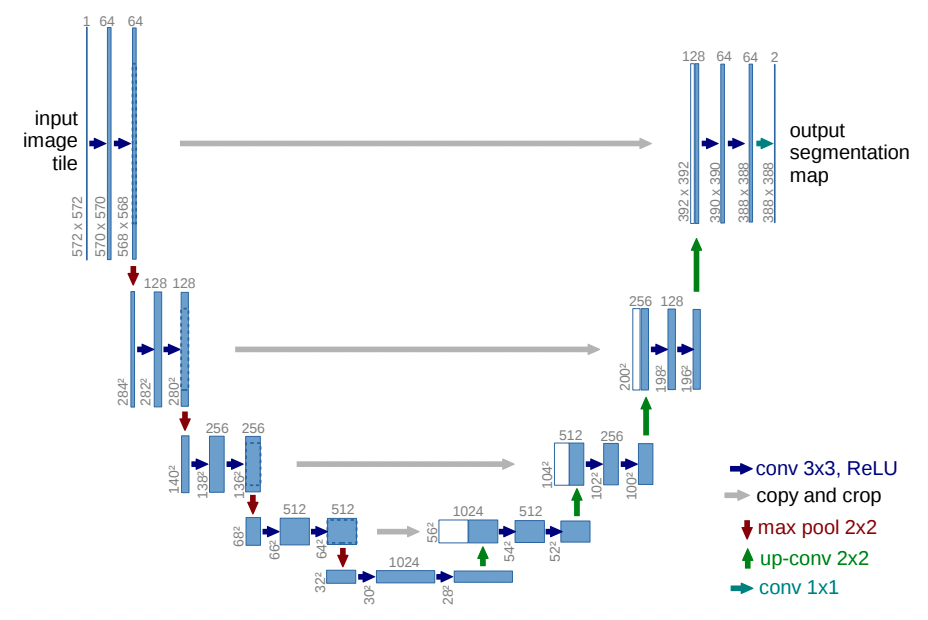

#### Pipeline Steps:

<ol>
    <li>Images and masks extraction</li>
    <li>Load training and validation images and masks</li>
    <li>Image augmentation</li>
    <li>Training segmentation model</li>
    <li>Load and test the model</li>
    <li>Results and plotting</li>
</ol>

### Project Structure:

.
├── README.md
├── config.py
├── dataset
│   └── images_and_masks
├── deployment
├── display_preds
├── image_processing
│   ├── convert.py
│   ├── data_augmentation.py
│   └── visualization.py
├── ircad-dataset
├── ircad.ipynb
├── model_serving_api
├── models
├── pipeline.py
├── preds
├── testing
│   ├── output.py
│   └── predict.py
├── training
│   ├── metrics.py
│   └── train.py
└── unet
    ├── data_loader.py
    ├── random_selection.py
    └── unet.py

### Hyperparameters:

In [29]:
# Hyperparameters
BATCH_SIZE = 10
EPOCHS = 50
LEARNING_RATE = 1e-3
VALIDATION_SPLIT = 0.2

### Image data visualization:

In [ ]:
'''
set data paths.
root data dir: data
'''
ROOT = '/path/to/root'
ds_path = f'{ROOT}/ircad-dataset'

In [23]:
'''
view data shape.
both images and masks will have the same shape.
only masks shape is shown here.
'''
# load a mask/image to view shape
train_masks = nibabel.load(f'{train_data_path}/ircad_e01_liver.nii.gz')
# get 3d numpy array
train_masks = train_masks.get_data()
print(f'mask shape: {train_masks.shape}')

(512, 512, 129)


/var/folders/cg/h7_fl0497c7dyn_wxbcjdl4c0000gn/T/ipykernel_4244/544972443.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  train_mask = train_mask.get_data()
/var/folders/cg/h7_fl0497c7dyn_wxbcjdl4c0000gn/T/ipykernel_4244/544972443.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  train_image = train_image.get_data()


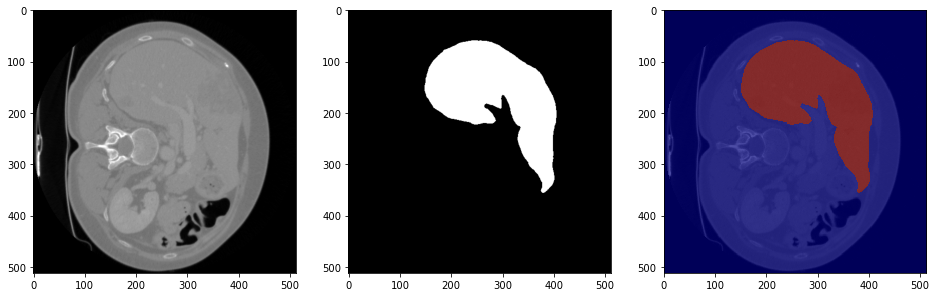

In [431]:
'''
train image and mask visualization.
slice 72 in the train image and mask has better/full view.
'''
from image_processing.visualization import *

train_mask = nibabel.load(f'{train_data_path}/ircad_e01_liver.nii.gz')
train_mask = train_mask.get_data()

train_image = nibabel.load(f'{train_data_path}/ircad_e01_orig.nii.gz')
train_image = train_image.get_data()

# pick a slice (72)
image = train_image[:, :, 72]
mask = train_mask[:, :, 72]

# plot an image, mask, and combined
plot_images([image], [mask])

### 1. Images and masks extraction:

In [16]:
from unet.random_selection import *

apply_dataset_masking()

INFO: splitting images and masks
INFO: process complete


### 2. Load train and validation images and masks:

In [19]:
from image_processing.convert import *

train_images, train_masks, val_images, val_masks = read_random_training_and_validation_data()

INFO: randomly selected train files: ['ircad_e14_orig.nii.gz', 'ircad_e06_orig.nii.gz', 'ircad_e05_orig.nii.gz', 'ircad_e06_orig.nii.gz', 'ircad_e01_orig.nii.gz', 'ircad_e16_orig.nii.gz', 'ircad_e06_orig.nii.gz', 'ircad_e10_orig.nii.gz', 'ircad_e01_orig.nii.gz', 'ircad_e07_orig.nii.gz']
INFO: randomly selected val files: ['ircad_e08_orig.nii.gz', 'ircad_e11_orig.nii.gz', 'ircad_e04_orig.nii.gz', 'ircad_e18_orig.nii.gz', 'ircad_e17_orig.nii.gz', 'ircad_e02_orig.nii.gz', 'ircad_e19_orig.nii.gz', 'ircad_e15_orig.nii.gz', 'ircad_e09_orig.nii.gz', 'ircad_e13_orig.nii.gz']
INFO: reading trainset..
INFO: trainset reading complete
INFO: reading valset..
INFO: valset reading complete


### 3. Image augmentation:

In [25]:
from image_processing.data_augmentation import *

train_images, train_masks = apply_image_augmentation(train_images, train_masks)
val_images, val_masks = apply_image_augmentation(val_images, val_masks)

INFO: augment trainset
INFO: trainset augmentation complete
INFO: augment validation set
INFO: validation set augmentation complete



### 4. Training segmentation model:

In [26]:
from training.train import *

history = train_model(train_images, train_masks)

training for fold 1
compiling model...
fitting model...
Epoch 1/50
2021-12-21 18:26:45.618382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
58/58 [==============================] - ETA: 0s - loss: 0.3608 - accuracy: 0.9682 - dice_coef: 0.6402
2021-12-21 18:27:23.655058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
58/58 [==============================] - 42s 701ms/step - loss: 0.3608 - accuracy: 0.9682 - dice_coef: 0.6402 - val_loss: 0.3293 - val_accuracy: 0.9743 - val_dice_coef: 0.6491
Epoch 2/50
58/58 [==============================] - 38s 660ms/step - loss: 0.0958 - accuracy: 0.9892 - dice_coef: 0.9044 - val_loss: 0.4429 - val_accuracy: 0.9689 - val_dice_coef: 0.5385
Epoch 3/50
58/58 [==============================] - 38s 652ms/step - loss: 0.0820 - accuracy: 0.9909 - dice_coef: 0.9178 - val_loss: 0.5201 - val_accuracy: 0

### 5. Load and test the model:

In [27]:
from testing.predict import *

predict(val_images)

loading weights
predicting masks...
20/20 [==============================] - 13s 666ms/step
saving prediction...



### 6. Results and plotting:

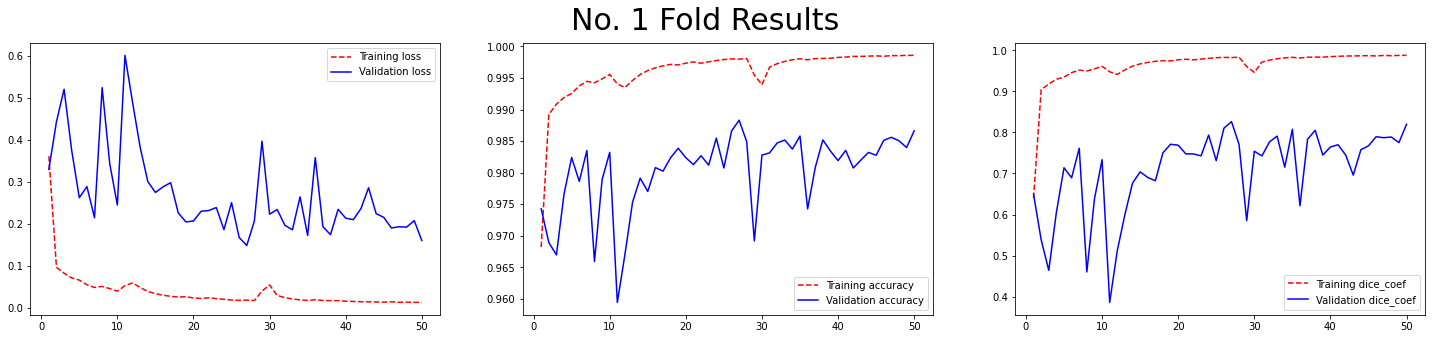

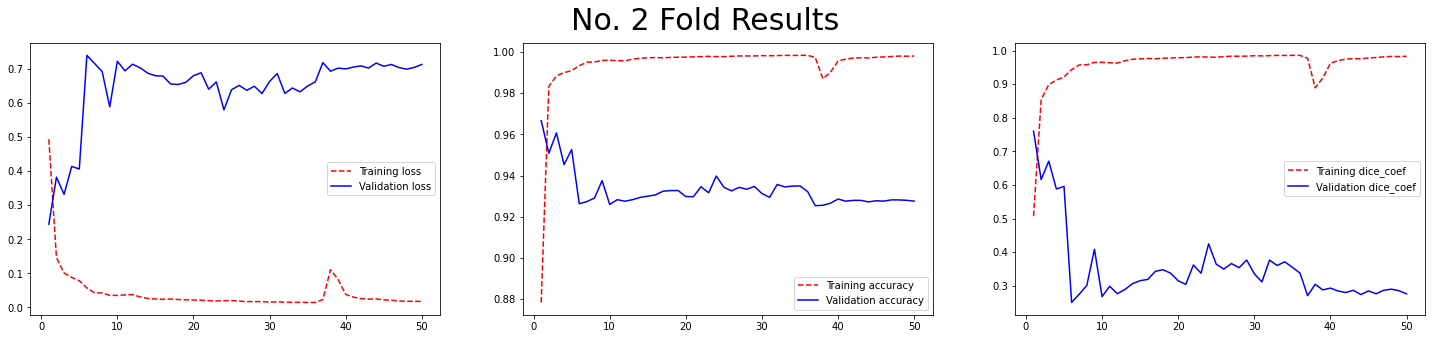

In [447]:
'''
plot training and validation loss, accuracy, and dice score.
the histories list contains all folds training history.
'''
from testing.output import *

plot_histories(histories)

In [448]:
print('average accuracy : ', np.mean(np.array(history.history['val_accuracy'])))
print('average loss : ', np.mean(np.array(history.history['val_loss'])))
print('average dicecoefs : ', np.mean(np.array(history.history['val_dice_coef'])))

average accuracy :  0.9329276859760285
average loss :  0.6465253165364265
average dicecoefs :  0.3512564218044281


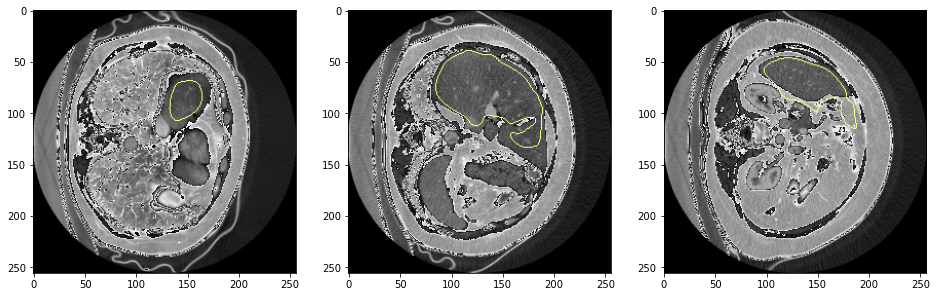

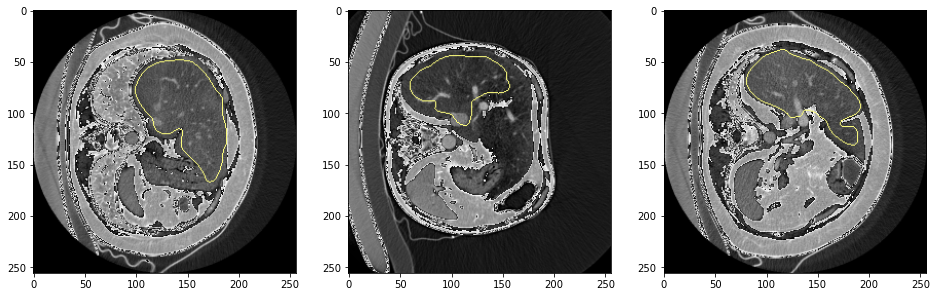

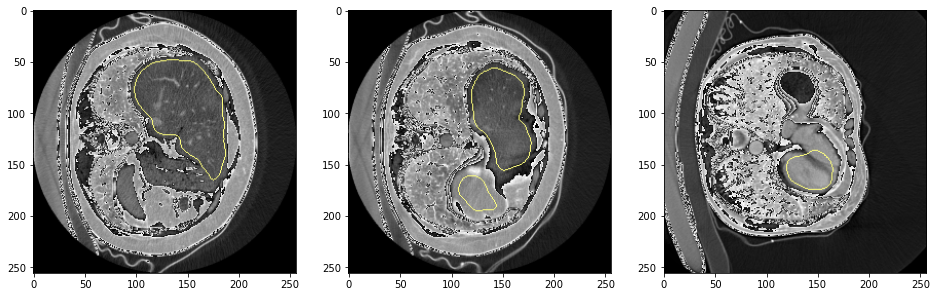

In [449]:
'''
plot training and validation loss, accuracy, and dice score.
the histories list contains all folds training history.
'''
from testing.output import *

display_segmented_images()

### Pipeline:

In [ ]:
from unet.random_selection import *
from image_processing.convert import *
from image_processing.data_augmentation import *
from training.train import *
from testing.predict import *
from testing.output import *
from testing.output import *


def pipeline():
    """
    step 1: apply dataset masking
        extract the CT scan images and masks
        store original images and masks separately
    """
    apply_dataset_masking()
    

    """
    step 2: load train and validation images and masks
        use numpy to load the train and validation dataset
        the process of dataset selection is random
    """
    train_images, train_masks, val_images, val_masks = read_random_training_and_validation_data()


    """
    step 3: image augmentation
        increase the number of sample by applying image augmentation
        currently implemented augmentation techniques
            left to right flip
            top to bottom flip
            image rotation
            gaussian blur
    """
    train_images, train_masks = apply_image_augmentation(train_images, train_masks)
    val_images, val_masks = apply_image_augmentation(val_images, val_masks)


    """
    step 4: train segmentation model
        backbone network: unet
    """
    history = train_model(train_images, train_masks)


    """
    step 5: load and test the trained model
        apply prediction on validation images
    """
    predict(val_images)


    """
    step 6: results and plotting
        plot training and validation loss, accuracy, and dice score.
        the histories list contains all folds training history.
    """
    plot_histories(histories)

    """
    plot training and validation loss, accuracy, and dice score.
    the histories list contains all folds training history.
    """
    display_segmented_images()

### Citations:

```{bibliography}
arxiv.org/pdf/1505.04597.pdf
```
```{bibliography}
github.com/zhixuhao/unet
```
```{bibliography}
IRCAD Dataset